In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=2 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 29543 
    Total predicted counts          : 29517.59
    Total off counts                : 101289.00

    Total background counts         : 20257.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 3.3 s, sys: 10.3 ms, total: 3.31 s
Wall time: 3.31 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 29631 
    Total predicted counts          : 29672.79
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 29292 
    Total predicted counts          : 29715.59
    Total off counts                : 102279.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_32 

    Total counts                    : 29728 
    Total predicted counts          : 29471.19
    Total off counts                : 101057.00

    Total background counts         : 20211.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.15

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_33 

    Total counts                    : 29771 
    Total predicted counts          : 29556.79
    Total off counts                : 101485.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 29444 
    Total predicted counts          : 29560.19
    Total off counts                : 101502.00

    Total background counts         : 20300.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_66 

    Total counts                    : 29495 
    Total predicted counts          : 29440.19
    Total off counts                : 100902.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 29642 
    Total predicted counts          : 29474.79
    Total off counts                : 101075.00

    Total background counts         : 20215.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_90 

    Total counts                    : 29453 
    Total predicted counts          : 29636.59
    Total off counts                : 101884.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_124 

    Total counts                    : 29434 
    Total predicted counts          : 29657.19
    Total off counts                : 101987.00

    Total background counts         : 20397.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_125 

    Total counts                    : 29595 
    Total predicted counts          : 29487.99
    Total off counts                : 101141.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_161 

    Total counts                    : 29817 
    Total predicted counts          : 29569.59
    Total off counts                : 101549.00

    Total background counts         : 20309.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 29766 
    Total predicted counts          : 29560.19
    Total off counts                : 101502.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_197 

    Total counts                    : 29747 
    Total predicted counts          : 29515.19
    Total off counts                : 101277.00

    Total background counts         : 20255.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_198 

    Total counts                    : 29184 
    Total predicted counts          : 29511.79
    Total off counts                : 101260.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_228 

    Total counts                    : 29775 
    Total predicted counts          : 29501.39
    Total off counts                : 101208.00

    Total background counts         : 20241.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_229 

    Total counts                    : 29629 
    Total predicted counts          : 29653.19
    Total off counts                : 101967.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_250 

    Total counts                    : 29884 
    Total predicted counts          : 29588.59
    Total off counts                : 101644.00

    Total background counts         : 20328.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_251 

    Total counts                    : 29717 
    Total predicted counts          : 29658.39
    Total off counts                : 101993.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_272 

    Total counts                    : 29888 
    Total predicted counts          : 29503.99
    Total off counts                : 101221.00

    Total background counts         : 20244.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_273 

    Total counts                    : 29496 
    Total predicted counts          : 29484.59
    Total off counts                : 101124.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_292 

    Total counts                    : 29746 
    Total predicted counts          : 29668.79
    Total off counts                : 102045.00

    Total background counts         : 20409.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_293 

    Total counts                    : 29717 
    Total predicted counts          : 29669.99
    Total off counts                : 102051.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_314 

    Total counts                    : 29697 
    Total predicted counts          : 29495.19
    Total off counts                : 101177.00

    Total background counts         : 20235.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_315 

    Total counts                    : 29650 
    Total predicted counts          : 29525.19
    Total off counts                : 101327.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 29656 
    Total predicted counts          : 29546.79
    Total off counts                : 101435.00

    Total background counts         : 20287.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_344 

    Total counts                    : 29478 
    Total predicted counts          : 29700.19
    Total off counts                : 102202.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_377 

    Total counts                    : 29485 
    Total predicted counts          : 29681.59
    Total off counts                : 102109.00

    Total background counts         : 20421.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_378 

    Total counts                    : 29526 
    Total predicted counts          : 29484.99
    Total off counts                : 101126.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_408 

    Total counts                    : 29659 
    Total predicted counts          : 29560.79
    Total off counts                : 101505.00

    Total background counts         : 20301.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 29533 
    Total predicted counts          : 29515.79
    Total off counts                : 101280.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_430 

    Total counts                    : 29497 
    Total predicted counts          : 29626.99
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_431 

    Total counts                    : 29555 
    Total predicted counts          : 29535.39
    Total off counts                : 101378.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_458 

    Total counts                    : 29959 
    Total predicted counts          : 29590.59
    Total off counts                : 101654.00

    Total background counts         : 20330.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_459 

    Total counts                    : 29377 
    Total predicted counts          : 29662.19
    Total off counts                : 102012.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_489 

    Total counts                    : 29679 
    Total predicted counts          : 29577.79
    Total off counts                : 101590.00

    Total background counts         : 20318.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_490 

    Total counts                    : 29647 
    Total predicted counts          : 29423.79
    Total off counts                : 100820.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_520 

    Total counts                    : 29433 
    Total predicted counts          : 29576.79
    Total off counts                : 101585.00

    Total background counts         : 20317.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_521 

    Total counts                    : 29613 
    Total predicted counts          : 29654.59
    Total off counts                : 101974.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_544 

    Total counts                    : 29478 
    Total predicted counts          : 29566.19
    Total off counts                : 101532.00

    Total background counts         : 20306.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_545 

    Total counts                    : 29454 
    Total predicted counts          : 29554.39
    Total off counts                : 101473.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_568 

    Total counts                    : 29380 
    Total predicted counts          : 29521.59
    Total off counts                : 101309.00

    Total background counts         : 20261.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 29828 
    Total predicted counts          : 29589.59
    Total off counts                : 101649.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_589 

    Total counts                    : 29705 
    Total predicted counts          : 29508.79
    Total off counts                : 101245.00

    Total background counts         : 20249.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_590 

    Total counts                    : 29772 
    Total predicted counts          : 29648.19
    Total off counts                : 101942.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_611 

    Total counts                    : 29671 
    Total predicted counts          : 29613.19
    Total off counts                : 101767.00

    Total background counts         : 20353.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_612 

    Total counts                    : 29764 
    Total predicted counts          : 29660.39
    Total off counts                : 102003.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_643 

    Total counts                    : 29308 
    Total predicted counts          : 29615.99
    Total off counts                : 101781.00

    Total background counts         : 20356.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_644 

    Total counts                    : 29556 
    Total predicted counts          : 29624.19
    Total off counts                : 101822.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_667 

    Total counts                    : 29769 
    Total predicted counts          : 29621.39
    Total off counts                : 101808.00

    Total background counts         : 20361.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_668 

    Total counts                    : 29804 
    Total predicted counts          : 29542.39
    Total off counts                : 101413.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_693 

    Total counts                    : 29730 
    Total predicted counts          : 29559.19
    Total off counts                : 101497.00

    Total background counts         : 20299.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_694 

    Total counts                    : 29749 
    Total predicted counts          : 29551.59
    Total off counts                : 101459.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_726 

    Total counts                    : 29428 
    Total predicted counts          : 29622.99
    Total off counts                : 101816.00

    Total background counts         : 20363.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_727 

    Total counts                    : 29409 
    Total predicted counts          : 29530.39
    Total off counts                : 101353.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_745 

    Total counts                    : 29776 
    Total predicted counts          : 29502.19
    Total off counts                : 101212.00

    Total background counts         : 20242.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_746 

    Total counts                    : 29659 
    Total predicted counts          : 29663.19
    Total off counts                : 102017.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_769 

    Total counts                    : 29472 
    Total predicted counts          : 29532.79
    Total off counts                : 101365.00

    Total background counts         : 20273.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_770 

    Total counts                    : 29706 
    Total predicted counts          : 29563.99
    Total off counts                : 101521.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_797 

    Total counts                    : 29440 
    Total predicted counts          : 29632.19
    Total off counts                : 101862.00

    Total background counts         : 20372.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_798 

    Total counts                    : 29470 
    Total predicted counts          : 29584.79
    Total off counts                : 101625.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_822 

    Total counts                    : 29549 
    Total predicted counts          : 29546.79
    Total off counts                : 101435.00

    Total background counts         : 20287.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_823 

    Total counts                    : 29771 
    Total predicted counts          : 29509.59
    Total off counts                : 101249.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_853 

    Total counts                    : 29731 
    Total predicted counts          : 29513.79
    Total off counts                : 101270.00

    Total background counts         : 20254.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_854 

    Total counts                    : 29627 
    Total predicted counts          : 29558.79
    Total off counts                : 101495.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_885 

    Total counts                    : 29596 
    Total predicted counts          : 29619.39
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_886 

    Total counts                    : 29536 
    Total predicted counts          : 29578.99
    Total off counts                : 101596.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_915 

    Total counts                    : 29562 
    Total predicted counts          : 29615.99
    Total off counts                : 101781.00

    Total background counts         : 20356.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_916 

    Total counts                    : 29733 
    Total predicted counts          : 29669.19
    Total off counts                : 102047.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_944 

    Total counts                    : 29308 
    Total predicted counts          : 29574.99
    Total off counts                : 101576.00

    Total background counts         : 20315.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_945 

    Total counts                    : 29660 
    Total predicted counts          : 29639.39
    Total off counts                : 101898.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_978 

    Total counts                    : 29364 
    Total predicted counts          : 29506.59
    Total off counts                : 101234.00

    Total background counts         : 20246.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_979 

    Total counts                    : 29611 
    Total predicted counts          : 29684.39
    Total off counts                : 102123.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

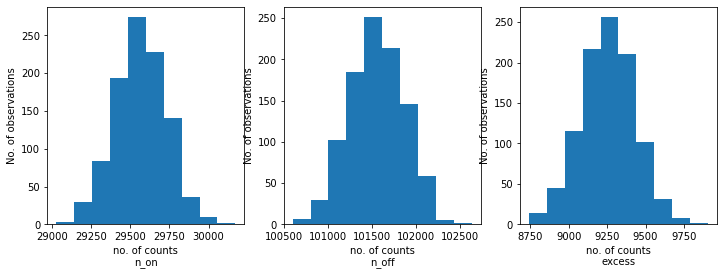

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 5min 42s, sys: 1.55 s, total: 5min 44s
Wall time: 6min 55s


In [15]:
results

[{'index': 2.285078513860973,
  'amplitude': 1.0707193841268212e-12,
  'lambda_': 1.7549757404234874},
 {'index': 2.1996324583985576,
  'amplitude': 1.2851232177832685e-12,
  'lambda_': 1.997248139660084},
 {'index': 2.2150850927687675,
  'amplitude': 1.3692600994164495e-12,
  'lambda_': 2.20388042489302},
 {'index': 2.1744685095939555,
  'amplitude': 1.462793993258135e-12,
  'lambda_': 2.2474813108859273},
 {'index': 2.243873278458896,
  'amplitude': 1.2666459861422052e-12,
  'lambda_': 1.9900955664082853},
 {'index': 2.224555841721795,
  'amplitude': 1.2790952762632778e-12,
  'lambda_': 2.0144251668081212},
 {'index': 2.3291540173955845,
  'amplitude': 9.829721114495055e-13,
  'lambda_': 1.6931848673905465},
 {'index': 2.1918609482837472,
  'amplitude': 1.4022834966072621e-12,
  'lambda_': 2.1229102661191366},
 {'index': 2.23233981236747,
  'amplitude': 1.2093207915318237e-12,
  'lambda_': 1.8886782502405552},
 {'index': 2.1711397774344117,
  'amplitude': 1.487073324677619e-12,
  'la

index: 2.216947494193627 += 0.051902875811568924


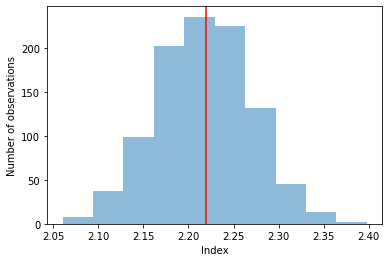

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.3132609579926914e-12 += 1.8380732543705423e-13


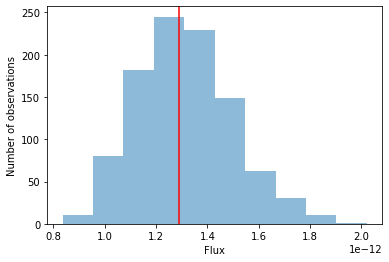

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 2.0189638337208007 += 0.2035076794342799


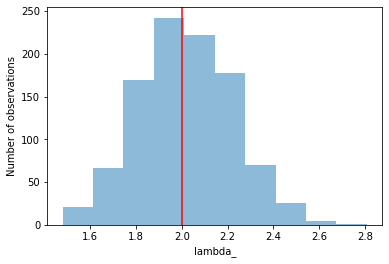

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")